In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

# CRF model

We consider the input image $I$ to be a graph $V$ with each node $v$ carrying pixel data (RGB). Then we can see about downsampling using e.g. SLIC.

We want to classify each node $v$ as foreground ($1$) or background ($-1$). For this, we will use a conditional random field (CRF) model specified over the nodes: the label likelihood factors as logistic regression given a latent variable $Z_v$ at node $v$:
$$
    p(l_v|Z_v;\theta) = g(l_v\theta^\intercal Z_v)\quad
    \text{where}\ g(u) = \frac{e^u}{e^u + 1}
$$
and $\theta$ is a parameter vector we learn over the set of examples.

The data likelihood is given by
$$
    \mathcal L(\theta; I) = \log\left(
        \sum_Z p(l|Z;\theta) p(Z|I)
    \right) =
    \log\left(\sum_Z
    \left[ \prod_{v\in V} 
            g(l_v\theta^\intercal Z_v)\right] p(Z|I)
    \right)
$$

In [45]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

import glob

IMAGE_FOLDER = "data/train/images"
MASKS_FOLDER = "data/train/masks"

IMAGES = sorted(glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg")))
MASKS = sorted(glob.glob(os.path.join(MASKS_FOLDER, "*.png")))

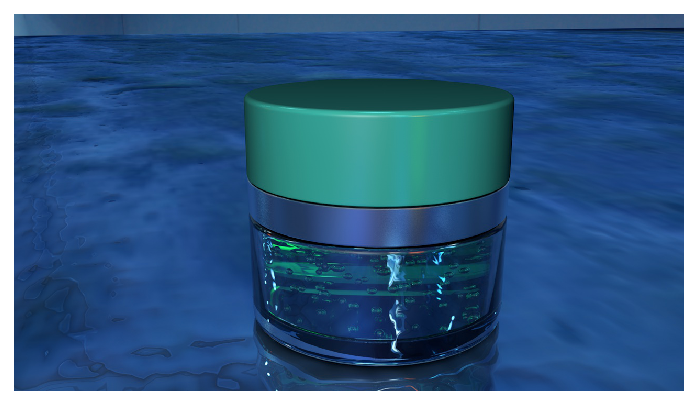

In [76]:
## Load an image
img = cv2.imread(IMAGES[22], cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASKS[22])

plt.imshow(img)
plt.axis('off');

## Smart downsampling with SLIC

We define a SLIC superpixel model with $N=400$ components.

In [77]:
from fast_slic.avx2 import SlicAvx2

In [78]:
slic = SlicAvx2(num_components=400, compactness=10)

In [79]:
assignments = slic.iterate(img)

In [80]:
from skimage import color
from skimage.segmentation import mark_boundaries

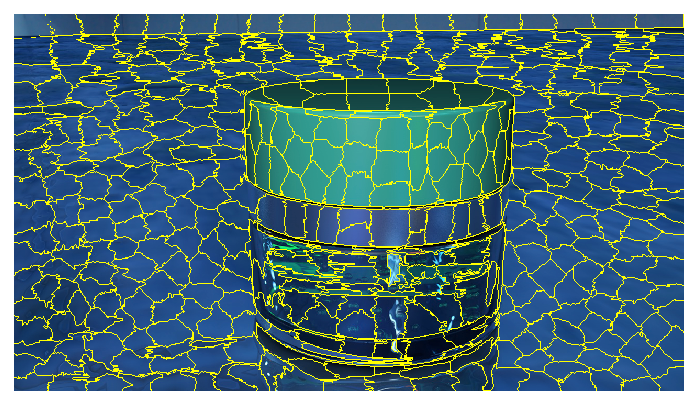

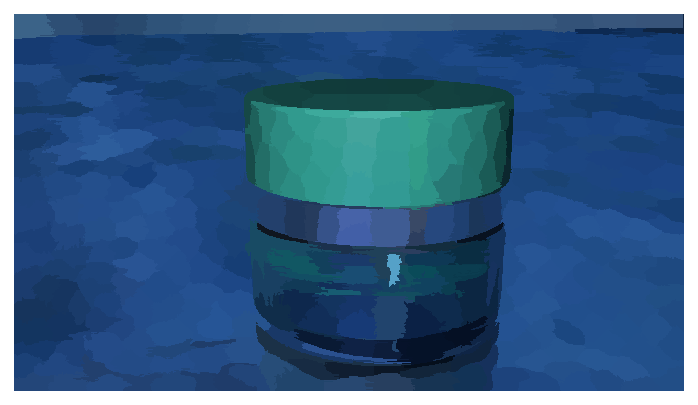

In [81]:
img_slic_boundaries = mark_boundaries(img, assignments)
img_slic = color.label2rgb(assignments, img, kind='avg')

plt.figure()
plt.imshow(img_slic_boundaries)
plt.axis('off')

plt.figure()
plt.imshow(img_slic)
plt.axis('off');

Now, we want to infer the labels of the SLIC cluster graph nodes.

In [82]:
## Recover the neighbors of each node
from utils import get_slic_graph

In [83]:
nodes, neighbors = get_slic_graph(slic, assignments)

In [84]:
print("NODE0:", nodes[0])
print("Neighbors:")
for n in neighbors[0]:
    print(nodes[n])

NODE0: {'number': 0, 'yx': (20.0, 34.0), 'color': (85.0, 122.0, 78.0), 'num_members': 966}
Neighbors:
{'number': 1, 'yx': (19.0, 97.0), 'color': (66.0, 128.0, 77.0), 'num_members': 812}
{'number': 41, 'yx': (106.0, 117.0), 'color': (55.0, 140.0, 60.0), 'num_members': 867}
{'number': 39, 'yx': (59.0, 1244.0), 'color': (51.0, 143.0, 56.0), 'num_members': 848}


In [85]:
nodes[0]['color']

(85.0, 122.0, 78.0)

In [112]:
mask[300, 600]

array([255, 255, 255], dtype=uint8)

In [119]:
nodes[0]

{'number': 0,
 'yx': (20.0, 34.0),
 'color': (85.0, 122.0, 78.0),
 'num_members': 966}

In [120]:
def get_node_mask(mask, nodes):
    out = np.empty((len(nodes),), dtype=int)
    for i, n in enumerate(nodes):
        y, x = n['yx']
        y = int(y); x = int(x)
        out[i] = mask[y,x, 0] > 0
    return out

In [122]:
mask_nodes = get_node_mask(mask, nodes)

## Conditionally deterministic $Z$

Let's define the latent variable $Z$ to be a deterministic feature function of the node data $X$.

In this case, the likelihood function collapses to
$$
    \mathcal L(\theta; X) = \log\left(
        p(l|Z;\theta) p(Z|X)
    \right) =
    \sum_{v\in V} 
    \log g(\theta^\intercal Z_v)
    + \log p(Z|X)
$$

An easy choice to recover image data is to say that for all nodes $v$, $Z_v$ is the graph Laplacian at $v$.

In [86]:
def get_laplacian_node(nodes, neighbors, i: int):
    node = nodes[i]
    neigh = neighbors[i]
    col = np.asarray(node['color'])
    if len(neigh) > 0:
        lap = 1./len(neigh) * np.sum([
            np.asarray(nodes[j]['color']) - col
            for j in neigh], axis=0)
    else:
        lap = np.zeros((3,))
    return lap

def get_laplacian(node, neighbors):
    """Get full Laplacian features for each color channel."""
    return np.array([
        get_laplacian_node(nodes, neighbors, i)
        for i in range(len(nodes))
    ])

In [87]:
Z = get_laplacian(nodes, neighbors)

In [94]:
from scipy.special import expit

In [98]:
from scipy.optimize import minimize

In [136]:
def compute_mle(labels):

    def objective(theta):
        return -np.sum(np.log(expit(labels * Z @ theta)))

    def gradient(theta):
        weights = expit(-labels * Z @ theta)[:, None]
        return -np.sum(labels * weights * Z, axis=0)
    
    prog = minimize(objective, np.random.rand(3), jac=gradient)
    return prog

In [137]:
labels = mask_nodes[:, None] * 2 - 1

In [138]:
res = compute_mle(labels)

In [139]:
res

      fun: 170.89285044532377
 hess_inv: array([[0.00029819, 0.00063572, 0.00044606],
       [0.00063572, 0.0017466 , 0.00120263],
       [0.00044606, 0.00120263, 0.0009266 ]])
      jac: array([-4.68229798e-06,  1.38756086e-06,  1.99690906e-06])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 18
     njev: 27
   status: 0
  success: True
        x: array([ 0.00880951,  0.02924963, -0.07488896])

In [140]:
def predict(theta):
    """Predict node label=1 probability."""
    return expit(Z @ theta)

In [146]:
prob_predict = predict(theta=res.x)

In [157]:
labels_predict = (prob_predict > .5).astype(int) * 2 - 1

In [158]:
labels_predict

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1,
       -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,
        1,  1, -1, -1, -1

In [154]:
from sklearn.metrics import accuracy_score

In [159]:
accuracy_score(labels, labels_predict)

0.8

## Stochastic $Z$

### EM algorithm